In [ ]:
import ROOT
import uproot
import math
import psutil,time
from tqdm import tqdm
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.stats import gamma as gamma_dist
from scipy.stats import lognorm as log_normal_dist
from scipy.stats import norm as gaussian_dist
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
from concurrent.futures import ThreadPoolExecutor
import pandas as pd
import os
import gc
import glob,random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
#from torch.utils.data import Dataset, DataLoader
import warnings
from torch_geometric.data import Data, Dataset,Batch
from torch_geometric.loader import DataLoader
from torch_geometric.nn import DynamicEdgeConv, global_max_pool,global_mean_pool,knn_graph,MessagePassing
from torch_scatter import scatter_max, scatter_mean
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import ReadRoot
plt.style.use('/home/llr/ilc/shi/code/Plot_style/cepc.mplstyle')
fig_size = (8, 6)
random_state = 42
BatchSize = 128
# 🔧 解码函数：根据 bitfield <id>calolayer:7,abslayer:1,cellid:13</id>
def decode_volid(volid):
    volid = int(volid)
    calolayer = volid & 0x7F                 # bits 0–6
    abslayer  = (volid >> 7) & 0x1           # bit 7
    cellid    = (volid >> 8) & 0x1FFF        # bits 8–20
    return calolayer, abslayer, cellid

# 🧮 从 cellid 解出 index_x/y/z（若 cellid = z*1600 + y*40 + x）
def decode_indices(cellid):
    index_z = cellid // 1600
    index_y = (cellid % 1600) // 40
    index_x = cellid % 40
    return index_x, index_y, index_z
def exp_func(x, a, b, c):
    return a * np.exp(b * x) + c

def plot_binned(x, y, num_bins=30, color="blue", label=None):
    """Plot mean y in bins of x."""
    bin_means, bin_edges, _ = binned_statistic(x, y, statistic='mean', bins=num_bins)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    plt.plot(bin_centers, bin_means, marker="o", linestyle="None", color=color, label=label)

mem = psutil.virtual_memory()
print(f"Total RAM: {mem.total / 1024**3:.2f} GB")
print(f"Used RAM: {mem.used / 1024**3:.2f} GB")
print(f"Available RAM: {mem.available / 1024**3:.2f} GB")
Memory_limit_gb=64  # GB
print("CPU logical cores:", os.cpu_count())
print("CPU physical cores:", psutil.cpu_count(logical=False))
CPU_cores_limit=psutil.cpu_count(logical=False)
MIP_table={# Si thickness (mm) : MIP (MeV)
    0.15:0.0410,
    0.3:0.0861,
    0.45:0.1328,
    0.6:0.1803,
    0.75:0.2282
}
Threshold_i=0.1
Si=0.75  # mm
CellSize=5.0  # mm
SamplingLayer=30
ECAL_layers=120
Layer_thickness=5.05  # mm
Threshold=Threshold_i*MIP_table[Si]
KNN_K=16
DataPath_Validate=f"/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X{CellSize:.1f}mm_Y{CellSize:.1f}mm_Si{Si:.2f}mm_layer{SamplingLayer}_in{ECAL_layers}"
DataPath_Uniform=f"/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Train/Merged_X{CellSize:.1f}mm_Y{CellSize:.1f}mm_Si{Si:.2f}mm_layer{SamplingLayer}_in{ECAL_layers}/Uniform"
Energy_test=(0.1,0.25,0.5,1.0,2.0,5.0,10.0,20.0,30.0,40.0,50.0,60.0)
pt_test_dir=f"{DataPath_Validate}/Graph_K{KNN_K}"
pt_uni_dir=f"{DataPath_Uniform}/Graph_K{KNN_K}"


Total RAM: 251.12 GB
Used RAM: 26.07 GB
Available RAM: 225.04 GB
CPU logical cores: 64
CPU physical cores: 32


In [ ]:

def ReadData_Energy(DataPath, ParticleEnergy, precision=0.01):
    pt_dir = f"{DataPath}/Graph_K{KNN_K}"
    if not os.path.exists(pt_dir):
        os.makedirs(pt_dir)
    max_mem = 0
    for energy_val in ParticleEnergy:
        input_file_name = f"{DataPath}/{energy_val}GeV.root"
        pt_file_name = f"{pt_dir}/{energy_val}GeV.pt"
        print(f"Reading file: {os.path.basename(input_file_name)}")
        Events = ReadRoot.read_root(input_file_name, threshold=Threshold,KNN_K=KNN_K)
        x_list, edge_list, y_list = [], [], []
        for i, ev in enumerate(Events):
            x_list.append(torch.tensor(list(zip(ev.pos_x, ev.pos_y, ev.pos_z, ev.energy)), dtype=torch.float))
            edge_list.append(torch.tensor(ev.edge_index, dtype=torch.int64).t().contiguous())
            y_list.append(torch.tensor([ev.E_truth], dtype=torch.float))
            if i % 1000 == 0:
                mem = psutil.virtual_memory().used / 1024**3
                if mem > max_mem:
                    max_mem = mem
                if mem > Memory_limit_gb:
                    print(f"Memory usage {mem:.2f} GB exceeded limit of {Memory_limit_gb} GB. Stopping further processing.")
                    break
        torch.save({
            "x_list": x_list,
            "edge_list": edge_list,
            "y_list": y_list
        }, pt_file_name)
    #print(f"Max RAM used during processing: {max_mem:.2f} GB")
    return pt_dir

def ReadData_Uniform(DataPath):
    pt_dir = f"{DataPath}/Graph_K{KNN_K}"
    if not os.path.exists(pt_dir):
        os.makedirs(pt_dir)
    max_mem = 0
    root_files = [os.path.join(DataPath, f) for f in os.listdir(DataPath) if f.endswith(".root")]
    if len(root_files) == 0:
        raise FileNotFoundError(f"No .root files found in {DataPath}")
    for input_file in root_files:
        print(f"Reading file: {os.path.basename(input_file)}")
        pt_file_name = f"{pt_dir}/{os.path.basename(input_file).replace('.root','.pt')}"
        Events = ReadRoot.read_root(input_file, threshold=Threshold,KNN_K=KNN_K)
        x_list, edge_list, y_list = [], [], []
        for i, ev in enumerate(Events):
            x_list.append(torch.tensor(list(zip(ev.pos_x, ev.pos_y, ev.pos_z, ev.energy)), dtype=torch.float))
            edge_list.append(torch.tensor(ev.edge_index, dtype=torch.int64).t().contiguous())
            y_list.append(torch.tensor([ev.E_truth], dtype=torch.float))
            if i % 1000 == 0:
                mem = psutil.virtual_memory().used / 1024**3
                if mem > max_mem:
                    max_mem = mem
                if mem > Memory_limit_gb:
                    print(f"Memory usage {mem:.2f} GB exceeded limit of {Memory_limit_gb} GB. Stopping further processing.")
                    break
        torch.save({
            "x_list": x_list,
            "edge_list": edge_list,
            "y_list": y_list
        }, pt_file_name)
    return pt_dir

DataPath_Validate=f"/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X{CellSize:.1f}mm_Y{CellSize:.1f}mm_Si{Si:.2f}mm_layer{SamplingLayer}_in{ECAL_layers}"
DataPath_Uniform=f"/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Train/Merged_X{CellSize:.1f}mm_Y{CellSize:.1f}mm_Si{Si:.2f}mm_layer{SamplingLayer}_in{ECAL_layers}/Uniform"
Energy_test=(0.1,0.25,0.5,1.0,2.0,5.0,10.0,20.0,30.0,40.0,50.0,60.0)#add 0.1 0.25 after all data is ready
#Energy_test=(60.0,)
pt_test_dir = ReadData_Energy(DataPath_Validate,Energy_test)
pt_uni_dir = ReadData_Uniform(DataPath_Uniform)

/tmp/ipykernel_3495916/3348155305.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(pt_file_name)


E_truth shape: (12500,), x shape: (8865052,), y shape: (8865052,), z shape: (8865052,)


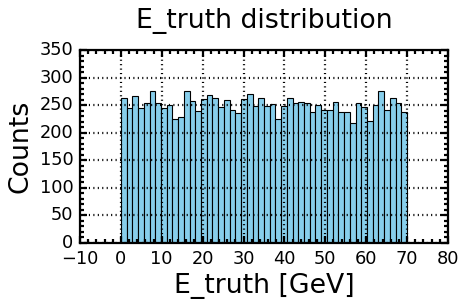

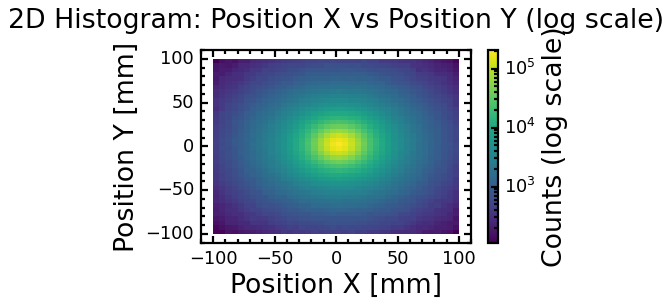

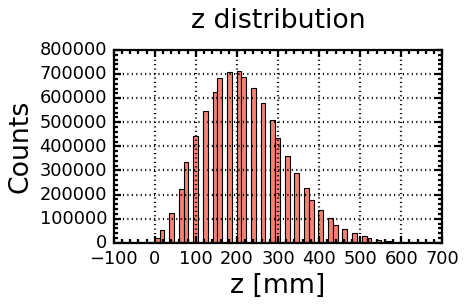

In [38]:
# pt_dir = f"{DataPath_Validate}/Graph_K{KNN_K}"
# pt_file_name = f"{pt_dir}/10.0GeV.pt"
pt_dir = pt_uni_dir
pt_file_name = f"{pt_dir}/0_70GeV_1.pt"
data = torch.load(pt_file_name)
x_list = data["x_list"]
y_list = data["y_list"]

E_truth = np.array([y.item() for y in y_list])
x = torch.cat([ev[:,0] for ev in x_list]).numpy()
y = torch.cat([ev[:,1] for ev in x_list]).numpy()
z = torch.cat([ev[:,2] for ev in x_list]).numpy()

print(f"E_truth shape: {E_truth.shape}, x shape: {x.shape}, y shape: {y.shape}, z shape: {z.shape}")

# --------------------------
# E_truth histogram
plt.figure(figsize=(6,4))
plt.hist(E_truth, bins=50, color='skyblue')
plt.xlabel("E_truth [GeV]")
plt.ylabel("Counts")
plt.title("E_truth distribution")
plt.tight_layout()
plt.show()

# --------------------------
# 2D histogram: PosX vs PosY
plt.figure(figsize=(6,4))
plt.hist2d(x, y, bins=[int(220/CellSize), int(220/CellSize)], range=[[-110, 110], [-110, 110]], cmap='viridis', norm=colors.LogNorm())
plt.colorbar(label='Counts (log scale)')
plt.xlabel("Position X [mm]")
plt.ylabel("Position Y [mm]")
plt.title("2D Histogram: Position X vs Position Y (log scale)")
plt.grid(False)
plt.tight_layout()
plt.show()
# --------------------------
# z histogram
plt.figure(figsize=(6,4))
plt.hist(z, bins=50, color='salmon')
plt.xlabel("z [mm]")
plt.ylabel("Counts")
plt.title("z distribution")
plt.tight_layout()
plt.show()


In [39]:

val_split = 0.2
pt_uni_files = sorted(glob.glob(f"{pt_uni_dir}/*.pt"))
random.seed(random_state)
random.shuffle(pt_uni_files)
n_val = int(len(pt_uni_files) * val_split)
data_list_val = pt_uni_files[:n_val]
data_list_train = pt_uni_files[n_val:]
data_list_test = sorted(glob.glob(f"{pt_test_dir}/*.pt"))

class MultiGraphFileDataset(Dataset):
    def __init__(self, file_list, event_limit=None):
        super().__init__()
        self.file_list = file_list
        self.file_offsets = []
        total = 0
        for fpath in tqdm(file_list, desc="Indexing files"):
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore",
                                      category=FutureWarning,
                                      message=r"You are using `torch\.load` with `weights_only=False`"),
                data_list = torch.load(fpath, map_location='cpu')
            n = len(data_list["x_list"])  # 假设 x_list, edge_list, y_list 长度一致
            self.file_offsets.append((total, total + n, fpath))
            total += n
        self.total_samples = total
        self.cache = {"fpath": None, "data_dict": None}
        self.event_limit = event_limit
    def __len__(self):
        #return self.total_samples
        if self.event_limit is not None:
            return min(self.total_samples, self.event_limit)
        return self.total_samples
    def __getitem__(self, idx):
        if self.event_limit is not None and idx >= self.event_limit:
            raise IndexError(f"Index {idx} exceeds event limit of {self.event_limit}")
        for start, end, fpath in self.file_offsets:
            if start <= idx < end:
                local_idx = idx - start
                if self.cache["fpath"] != fpath:
                    with warnings.catch_warnings():
                        warnings.filterwarnings(
                            "ignore",
                            category=FutureWarning,
                            message=r"You are using `torch\.load` with `weights_only=False`"
                        )
                        self.cache["data_dict"] = torch.load(fpath, map_location="cpu")
                    self.cache["fpath"] = fpath
                data_dict = self.cache["data_dict"]
                x = data_dict["x_list"][local_idx]
                edge_index = data_dict["edge_list"][local_idx]
                y = data_dict["y_list"][local_idx]
                return Data(x=x, edge_index=edge_index, y=y)
        raise IndexError(f"Index {idx} out of range")
        
train_dataset = MultiGraphFileDataset(file_list=data_list_train)
val_dataset = MultiGraphFileDataset(file_list=data_list_val)
test_dataset = MultiGraphFileDataset(file_list=data_list_test)
train_loader = DataLoader(train_dataset, batch_size=BatchSize, num_workers=CPU_cores_limit//4,pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BatchSize, num_workers=CPU_cores_limit//4,pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BatchSize, shuffle=False, num_workers=CPU_cores_limit//4,pin_memory=True)

Indexing files: 100%|██████████| 12/12 [00:08<00:00,  1.47it/s]


In [40]:
class RelativeMSELoss(nn.Module):
    def __init__(self, eps=1e-8):
        super().__init__()
        self.eps = eps
    def forward(self, y_pred, y_true):
        rel = (y_pred - y_true) / (y_true + self.eps)
        return torch.mean(rel**2)
class RelativeMSELoss_Power3(nn.Module):
    def __init__(self, eps=1e-8, power=3):
        super().__init__()
        self.eps = eps
        self.power = power
    def forward(self, y_pred, y_true):
        out = ((y_pred - y_true)**2) / ((y_true + self.eps)**self.power)
        return torch.mean(out)   
class HuberRelativeLoss(nn.Module):
    def __init__(self, delta=0.1, eps=1e-8):
        super().__init__()
        self.delta = delta
        self.eps = eps
    def forward(self, y_pred, y_true):
        rel = (y_pred - y_true) / (y_true + self.eps)
        abs_rel = torch.abs(rel)
        #Basic
        loss = torch.where(abs_rel < self.delta, 0.5 * rel**2, self.delta * (abs_rel - 0.5*self.delta))
        #Test
        #base = torch.where(abs_rel < self.delta, 0.5 * rel**2, self.delta * (abs_rel - 0.5*self.delta))
        #loss = base * (1 + abs_rel)
        #loss = torch.where(abs_rel < self.delta, 0.5 * rel**2, 0.5 * (abs_rel - self.delta + self.delta**2))
        #loss = torch.where(square < 0.01, 0.5 * rel**3, self.delta * (abs_rel - 0.5*self.delta))
        return torch.mean(loss)
class ResidualLinearBlock(nn.Module):
    def __init__(self, in_features, out_features, dropout=0.1, activation=None):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.activation = activation if activation is not None else nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.shortcut = nn.Linear(in_features, out_features) if in_features != out_features else nn.Identity()

    def forward(self, x):
        identity = self.shortcut(x)
        out = x
        #out = self.activation(out)
        out = self.linear(out)
        out = self.activation(out)
        out = self.dropout(out)
        out = out + identity
        return out
    
#General MLP with residual blocks, no need for input dim
class MLPRegressor(nn.Module):
    def __init__(self, hidden_dims=[128, 64, 32], dropout=0.1, activation=nn.PReLU()):
        super().__init__()
        self.inferred_input_dim = None
        print(f"Hidden dims: {hidden_dims}, Dropout: {dropout}, Activation: {activation}")
        layers = []
        layers.append(nn.Sequential(
            nn.LazyBatchNorm1d(),
            nn.LazyLinear(hidden_dims[0]),
            activation,
            nn.Dropout(dropout)
        ))
        prev_dim = hidden_dims[0]
        for h in hidden_dims[1:]:
            layers.append(ResidualLinearBlock(prev_dim, h, dropout=dropout, activation=activation))
            prev_dim = h

        self.model = nn.Sequential(*layers)
        self.output_layer = nn.Linear(prev_dim, 1)  # 输出事件预测

    def forward(self, x):
        if self.inferred_input_dim is None:
            self.inferred_input_dim = x.shape[-1]
            print(f"MLP input dim: {self.inferred_input_dim}")
        x = self.model(x)
        # return self.output_layer(x).squeeze(-1)
        return x

class EdgeConv(nn.Module):
    def __init__(self, hidden_layers=[32,32,32], dropout=0.1, activation=nn.PReLU()):
        super().__init__()
        self.mlp = MLPRegressor(hidden_dims=hidden_layers, dropout=dropout, activation=activation)
    def forward(self, x, edge_index):
        row, col = edge_index
        x_i, x_j = x[row], x[col]
        edge_feat = torch.cat([x_i, x_j - x_i], dim=-1)
        out = self.mlp(edge_feat)
        #out,_ = scatter_max(out, row, dim=0, dim_size=x.size(0))
        out = scatter_mean(out, row, dim=0, dim_size=x.size(0))
        return out

class DGCNN_MLP(nn.Module):
    def __init__(self, EdgeMLP_hidden=[[128,128],[64,64]], mlp_hidden=[128,64,32], dropout=0.1, activation=nn.PReLU()):
        super().__init__()
        self.edge_convs = nn.ModuleList()
        for hidden in EdgeMLP_hidden:
            self.edge_convs.append(
                EdgeConv(hidden_layers=hidden, dropout=dropout, activation=activation)
            )
        print(f"Edge MLP hidden dims per layer: {EdgeMLP_hidden}, Dropout: {dropout}, Activation: {activation}")

        print(f"MLP hidden dims: {mlp_hidden}, Dropout: {dropout}, Activation: {activation}")
        self.mlp = MLPRegressor(hidden_dims=mlp_hidden, dropout=dropout, activation=activation)
        print(f"Output layer: Linear({mlp_hidden[-1]} -> 1)")
        self.energy_output_layer = nn.Linear(mlp_hidden[-1], 1)

    def forward(self, data):
        x = data.x
        for conv in self.edge_convs:
            x = conv(x, data.edge_index)
        x = global_mean_pool(x, data.batch)
        if hasattr(data, 'extra') and data.extra is not None:
            combined = torch.cat([x, data.extra], dim=-1)
        else:
            combined = x
        out = self.mlp(combined)
        out = self.energy_output_layer(out).squeeze(-1)
        return out

In [41]:
def train_dgcnn(train_loader, val_loader,
            activation=nn.Sigmoid(),
            loss=HuberRelativeLoss(),
            EdgeMLP_dims=[64, 128],
              mlp_dims=[128, 64, 32], 
              dropout=0.1, 
              lr=1e-3,
              weight_decay=5e-5, 
              batch_size=4096, 
              epochs=30,
              patience=10,
              val_split=0.2,
              random_state=42,
              model_name="DGCNN_model.pth"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    torch.manual_seed(random_state)
    np.random.seed(random_state)
    torch.cuda.manual_seed_all(random_state)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print(f"Using device: {device}")
    print(f"Random state: {random_state}")
    print(f"Training samples: {len(train_loader.dataset)}, Validation samples: {len(val_loader.dataset)}")
    print(f"learning rate: {lr}, batch size: {batch_size}, epochs: {epochs}, patience: {patience}")
    print(f"Loss function: {loss}")

    # Model
    model = DGCNN_MLP(
        EdgeMLP_hidden=EdgeMLP_dims,
        mlp_hidden=mlp_dims,
        dropout=dropout,
        activation=activation
    ).to(device)
    
    # Optimizer & Loss
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = loss

    warmup_epochs = 5
    base_lr = lr
    min_lr = 1e-5

    def lr_lambda(current_epoch):
        if current_epoch <= warmup_epochs:
            return float(current_epoch + 1) / warmup_epochs
        else:
            progress = (epochs/50) * (current_epoch - warmup_epochs) / (epochs - warmup_epochs)
        return 0.5 * (1 + math.cos(math.pi * progress))  # 范围 0~1
    scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)
    # === Training loop with best model tracking ===
    best_val_loss = float("inf")
    best_state_dict = None
    train_loss_history, val_loss_history, beta_history = [],  [], []
    patience_counter = 0
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            pred = model(batch)
            loss = criterion(pred, batch.y)
            loss.backward()
            #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()
            train_loss += loss.item() * batch.num_graphs
            mem = psutil.virtual_memory().used / 1024**3
            if mem > Memory_limit_gb:
                print(f"Memory usage {mem:.2f} GB exceeded limit of {Memory_limit_gb} GB. Stopping training.")
                return model, None, None, None
        scheduler.step()        
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                pred = model(batch)
                loss = criterion(pred, batch.y)
                val_loss += loss.item() * batch.num_graphs
        train_loss /= len(train_loader.dataset)
        val_loss   /= len(val_loader.dataset)
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        print(f"Epoch {epoch+1:03d}/{epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}| LR: {scheduler.get_last_lr()[0]:.6f}｜ patience: {patience_counter}")

        # Nan stopping
        if np.isnan(train_loss) or np.isnan(val_loss):
            print("NaN encountered. Stopping training.")
            break
        # Early stopping based on validation loss
        if val_loss < best_val_loss:
            if (best_val_loss - val_loss) / best_val_loss > 0.01:
                patience_counter = 0
            best_val_loss = val_loss
            best_state_dict = model.state_dict()    
            torch.save(model, model_name)
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # Restore best model
    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)
    
    plt.figure(figsize=fig_size)
    plt.plot(train_loss_history, label="Train Loss")
    plt.plot(val_loss_history, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
    model.eval()
    y_val_true, y_val_pred = [], []
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            pred = model(batch)
            y_val_true.append(batch.y.cpu())
            y_val_pred.append(pred.cpu())
    y_val_true = torch.cat(y_val_true, dim=0).numpy()
    y_val_pred = torch.cat(y_val_pred, dim=0).numpy()
    return model,y_val_true, y_val_pred,best_val_loss

Using device: cuda
Random state: 42
Training samples: 999720, Validation samples: 249933
learning rate: 0.0005, batch size: 128, epochs: 50, patience: 10
Loss function: HuberRelativeLoss()
Hidden dims: [64, 64, 64], Dropout: 0.1, Activation: PReLU(num_parameters=1)
Hidden dims: [128, 128, 128], Dropout: 0.1, Activation: PReLU(num_parameters=1)
Edge MLP hidden dims per layer: [[64, 64, 64], [128, 128, 128]], Dropout: 0.1, Activation: PReLU(num_parameters=1)
MLP hidden dims: [128, 64, 32], Dropout: 0.1, Activation: PReLU(num_parameters=1)
Hidden dims: [128, 64, 32], Dropout: 0.1, Activation: PReLU(num_parameters=1)
Output layer: Linear(32 -> 1)


MLP input dim: 8
MLP input dim: 128
MLP input dim: 128
Epoch 001/50 | Train Loss: 0.013909 | Val Loss: 0.003260| LR: 0.000200｜ patience: 0
Epoch 002/50 | Train Loss: 0.004758 | Val Loss: 0.002098| LR: 0.000300｜ patience: 0
Epoch 003/50 | Train Loss: 0.003254 | Val Loss: 0.001462| LR: 0.000400｜ patience: 0
Epoch 004/50 | Train Loss: 0.002679 | Val Loss: 0.001457| LR: 0.000500｜ patience: 0
Epoch 005/50 | Train Loss: 0.002464 | Val Loss: 0.001731| LR: 0.000600｜ patience: 0
Epoch 006/50 | Train Loss: 0.002314 | Val Loss: 0.002696| LR: 0.000499｜ patience: 1
Epoch 007/50 | Train Loss: 0.001988 | Val Loss: 0.001599| LR: 0.000498｜ patience: 2
Epoch 008/50 | Train Loss: 0.001832 | Val Loss: 0.001765| LR: 0.000495｜ patience: 3
Epoch 009/50 | Train Loss: 0.001679 | Val Loss: 0.001745| LR: 0.000490｜ patience: 4
Epoch 010/50 | Train Loss: 0.001623 | Val Loss: 0.001703| LR: 0.000485｜ patience: 5
Epoch 011/50 | Train Loss: 0.001499 | Val Loss: 0.002345| LR: 0.000478｜ patience: 6
Epoch 012/50 | Train 

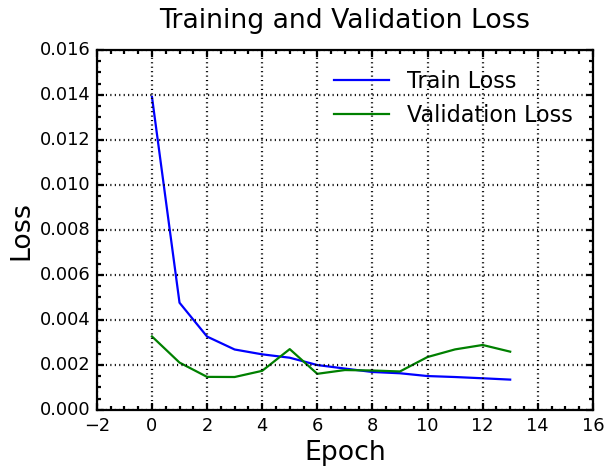

In [42]:
gc.collect()
torch.cuda.empty_cache()
torch.cuda.synchronize()
CONF_NAME=f"KNN{KNN_K}_WD1e-8"
model_name = DataPath_Validate+f"/Models/{CONF_NAME}.pth"
dgcnn_model, y_val_true, y_val_pred, best_val_loss = train_dgcnn(
    train_loader=train_loader,
    val_loader=val_loader,
    activation=nn.PReLU(),
    loss=HuberRelativeLoss(delta=0.05),
    EdgeMLP_dims=[[64,64,64],[128,128,128]],
    mlp_dims=[128, 64, 32],
    dropout=0.1,
    lr=5e-4,
    weight_decay=1e-8,
    batch_size=BatchSize,
    epochs=50,
    patience=10,
    val_split=0.2,
    random_state=random_state,
    model_name=model_name
)
# Evaluate on test set

Step 1 Linear fit coeffs: [ 0.00119097 -0.1111883 ]


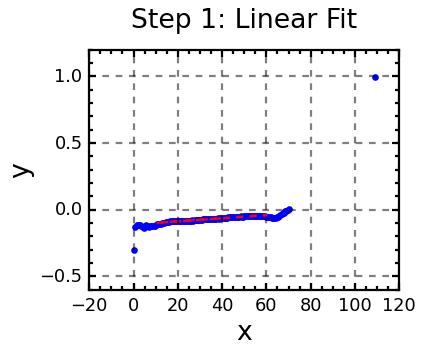

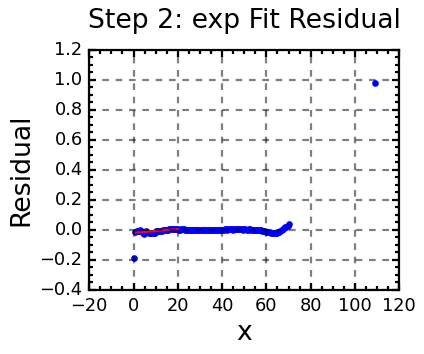

Step 3 Linear fit coeffs: [ 0.00119141 -0.11119065]


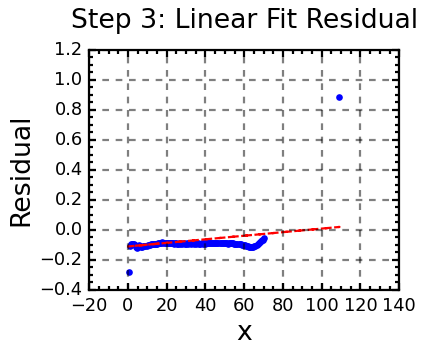

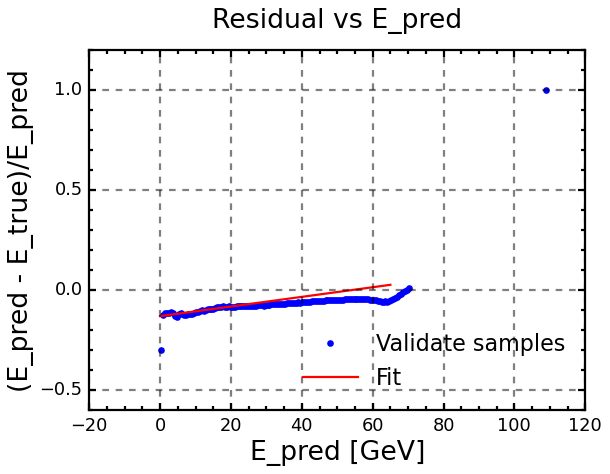

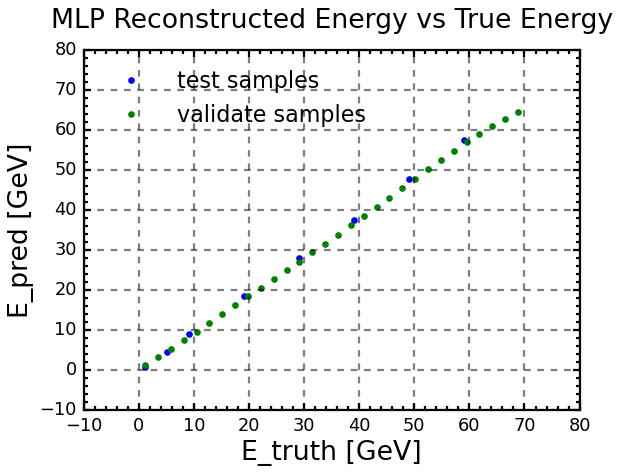

In [43]:
def Combined_fit(x, y, fit_range=(0,65), plot=True, num_bins=100):
    #Step 1: Linear
    linear_range = (10,60)
    mask_lin = (x > linear_range[0]) & (x < linear_range[1])
    coeffs_lin = np.polyfit(x[mask_lin], y[mask_lin], 1)
    y_lin = np.poly1d(coeffs_lin)(x)
    residual = y - y_lin
    print("Step 1 Linear fit coeffs:", coeffs_lin)
    
    if plot:
        plt.figure(figsize=(5,4))
        plot_binned(x, y, num_bins=num_bins, color="blue", label="Data (bin mean)")
        plt.plot(x[mask_lin], y_lin[mask_lin], color="red", linestyle="--", label="Step1: Linear")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title("Step 1: Linear Fit")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.show()
    
    # Step 2: exp fit
    #residual = y
    fit_range = (1, 20)
    mask_fit = (x > fit_range[0]) & (x < fit_range[1])
    def fit_func2(x, a, b, c):
        return a * np.exp(b * x) + c
    coeff_fit2, _ = curve_fit(fit_func2, x[mask_fit], residual[mask_fit], p0=(1, -0.1, 0))
    x_fit2 = np.linspace(fit_range[0], fit_range[1], 200)
    y_fit2 = fit_func2(x_fit2, *coeff_fit2)
    if plot:
        plt.figure(figsize=(5,4))
        plot_binned(x, residual, num_bins=num_bins, color="blue", label="Residual (bin mean)")
        plt.plot(x_fit2, y_fit2, color="red", linestyle="-", label="Step2: exp Fit")
        plt.xlabel("x")
        plt.ylabel("Residual")
        plt.title("Step 2: exp Fit Residual")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.show()

    residual = y - fit_func2(x, *coeff_fit2)

    # Step 3: exp fit
    # if plot:
    #     plt.figure(figsize=(5,4))
    #     plot_binned(x, residual, num_bins=num_bins, color="blue", label="Residual (bin mean)")
    #     plt.xlabel("x")
    #     plt.ylabel("Residual")
    #     plt.title("Step 3: exp Fit Residual")
    #     plt.grid(True, linestyle="--", alpha=0.5)
    #     plt.show()
    # fit_range = (10, 30)
    # mask_fit = (x > fit_range[0]) & (x < fit_range[1])
    # def fit_func3(x, a, b, c):
    #     return a * np.exp(b * x) + c
    # coeff_fit3, _ = curve_fit(fit_func3, x[mask_fit], residual[mask_fit], p0=(1, -0.1, 0))
    # x_fit3 = np.linspace(fit_range[0], fit_range[1], 200)
    # y_fit3 = fit_func3(x_fit3, *coeff_fit3)
    # if plot:
    #     plt.plot(x_fit3, y_fit3, color="red", linestyle="-", label="Step3: exp Fit")

    # residual = y - fit_func2(x, *coeff_fit2) - fit_func3(x, *coeff_fit3)

    # Step 4: Linear again
    mask_fit = (x > fit_range[0]) & (x < fit_range[1])
    params_lin2 = np.polyfit(x[mask_fit], residual[mask_fit], 1)
    y_lin2 = np.poly1d(params_lin2)(x)
    print("Step 3 Linear fit coeffs:", params_lin2)
    
    if plot:
        plt.figure(figsize=(5,4))
        plot_binned(x, residual, num_bins=num_bins, color="blue", label="Residual after Step2 (bin mean)")
        plt.plot(x, y_lin2, color="red", linestyle="--", label="Step3: Linear Fit")
        plt.xlabel("x")
        plt.ylabel("Residual")
        plt.title("Step 3: Linear Fit Residual")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.show()
    
    # Final combined function
    def f(x_val):
        return ( 
                fit_func2(x_val, *coeff_fit2) + 
                #fit_func3(x_val, *coeff_fit3) + 
                np.poly1d(params_lin2)(x_val))
    return f
def build_reco_hist(y_pred, y_truth, Energy_test, Nbins=50):
    reco_hist = []
    for i_E, E_truth in enumerate(Energy_test):
        mask = ( np.isclose(y_truth, E_truth) )
        reco_energy = y_pred[mask]

        if len(reco_energy) == 0:
            print(f"No events found for E_truth = {E_truth} GeV, skipping.")
            continue

        mean = np.mean(reco_energy)
        rms = np.std(reco_energy)
        valid_mask = (reco_energy >= mean - 5*rms) & (reco_energy <= mean + 5*rms)

        filtered_data = reco_energy[valid_mask]
        counts, bin_edges = np.histogram(filtered_data, bins=Nbins)

        reco_hist.append({
            "E_truth": E_truth,
            "counts": counts,
            "bin_edges": bin_edges
        })
    return reco_hist

Reco_hist_all = []

gc.collect()
torch.cuda.empty_cache()
torch.cuda.synchronize()
device = next(dgcnn_model.parameters()).device
dgcnn_model.eval()
y_test_true, y_test_pred = [], []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred = dgcnn_model(batch)
        y_test_true.append(batch.y.cpu())
        y_test_pred.append(pred.cpu())
y_test_true = torch.cat(y_test_true, dim=0).numpy()
y_test_pred = torch.cat(y_test_pred, dim=0).numpy()

Reco_hist_all.clear()
Reco_hist = build_reco_hist(y_test_pred, y_test_true, Energy_test, Nbins=50)
Reco_hist_all.append(Reco_hist)

fit_range = (0, 65) 
mask = y_val_pred>0
residual_E = (y_val_pred[mask] - y_val_true[mask]) / y_val_pred[mask]
E_calib_fit = Combined_fit(y_val_pred[mask], residual_E, fit_range=fit_range, plot=True, num_bins=200)
x_fit = np.linspace(fit_range[0], fit_range[1], 200)
y_fit = E_calib_fit(x_fit)
plt.figure(figsize=fig_size)
plot_binned(y_val_pred[mask], residual_E, num_bins=200, color="blue", label="Validate samples")
#plot_binned(y_pred_test_mlp, (y_pred_test_mlp - y_test) / y_pred_test_mlp,num_bins=200, color="orange", label="Test samples")
plt.plot(x_fit, y_fit, color='red', label='Fit')
plt.xlabel("E_pred [GeV]")
plt.ylabel("(E_pred - E_true)/E_pred")
plt.title("Residual vs E_pred")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(loc="lower right")
plt.show()

y_val_pred_calib = y_val_pred*(1-E_calib_fit(y_val_pred))
y_test_pred_calib = y_test_pred*(1-E_calib_fit(y_test_pred))
Reco_hist_all.clear()
Reco_hist = build_reco_hist(y_test_pred_calib, y_test_true, Energy_test, Nbins=100)
Reco_hist_all.append(Reco_hist)

plt.figure(figsize=fig_size)
plot_binned(y_test_true, y_test_pred, color="blue", label="test samples")
plot_binned(y_val_true, y_val_pred, color="green", label="validate samples")
plt.xlabel("E_truth [GeV]")
plt.ylabel("E_pred [GeV]")
plt.title("MLP Reconstructed Energy vs True Energy")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(loc="upper left")  
plt.show()


In [44]:
def fit_gamma(x, norm, k, mu, theta):
    return norm * gamma_dist.pdf(x, k, loc=mu, scale=theta)

def fit_log_normal(x, norm, sigma, loc, scale):
    """Log-normal distribution with location parameter."""
    return norm * log_normal_dist.pdf(x, s=sigma, loc=loc, scale=scale)

def fit_gaussian(x, norm, resolution, mean):
    return norm * gaussian_dist.pdf(x, loc=mean, scale=mean * resolution)

def fit_all(type,E_truth,counts,bin_edges):
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    dx = bin_edges[1] - bin_edges[0]
    peak = bin_centers[np.argmax(counts)]
    mean = np.average(bin_centers, weights=counts)
    rms = np.sqrt(np.average((bin_centers - mean)**2, weights=counts))
    print(f"Mean: {mean}, Peak: {peak}, RMS: {rms}")
    plt.figure(figsize=fig_size)
    plt.bar(bin_centers, counts, width=bin_edges[1]-bin_edges[0], alpha=0.6, label="Data", color='blue')

    #Gamma Fit
    #theta = abs(mean - peak)
    #k = rms / np.sqrt(theta)
    #mu = E_truth
    theta = max(rms, 1e-6)
    k = max((mean - bin_edges[0]) / theta, 1e-3)
    mu = bin_edges[0] # or try mean - k*theta
    norm = counts.sum() * dx
    params_gamma_initial = [norm, k, mu, theta]
    lower_bounds = [norm*0.01, k*0.1-1, mu*0.1-1, theta*0.1]
    upper_bounds = [norm*6, k*10, mu*1.5+10, theta*10]
    print(f"Initial Gamma Fit Parameters: {params_gamma_initial}")
    print(f"Gamma Fit Bounds: lower {lower_bounds}, \n upper {upper_bounds}")
    params_gamma, cov_gamma = curve_fit(fit_gamma, bin_centers, counts, p0=params_gamma_initial, bounds=(lower_bounds, upper_bounds))
    print(f"Gamma Fit Parameters: {params_gamma}")
    x_fit_gamma = np.linspace(bin_edges[0], bin_edges[-1], 100)
    y_fit_gamma = fit_gamma(x_fit_gamma, *params_gamma)
    #calculate peak and resolution
    k,mu,theta = params_gamma[1], params_gamma[2], params_gamma[3]
    peak_gamma = (k-1) * theta + mu
    J = np.array([0,theta, 1.0, (k - 1.0)])
    peak_gamma_error = np.sqrt(J @ cov_gamma @ J)
    mean_gamma = k * theta + mu
    J = np.array([0,theta, 1.0, k])
    mean_gamma_error = np.sqrt(J @ cov_gamma @ J)
    #res
    res_gamma = np.sqrt(k) * theta / peak_gamma
    dr_dnorm = 0.0
    dr_dk = (0.5 / np.sqrt(k) * theta * peak_gamma - np.sqrt(k) * theta * (theta)) / (peak_gamma**2)
    dr_dmu = - np.sqrt(k) * theta / (peak_gamma**2)
    dr_dtheta = (np.sqrt(k) * peak_gamma - np.sqrt(k) * theta * (k - 1.0)) / (peak_gamma**2)
    J = np.array([dr_dnorm, dr_dk, dr_dmu, dr_dtheta])
    res_gamma_error = np.sqrt(J @ cov_gamma @ J)
    print(f"Gamma Fit Peak: {peak_gamma} ± {peak_gamma_error}, Mean: {mean_gamma} ± {mean_gamma_error}, Resolution: {res_gamma} ± {res_gamma_error}")
    if type == "E":
        plt.title(f"Deposited Energy {E_truth} GeV")
        plt.xlabel("Deposited Energy [MeV]")
        plt.ylabel("Counts")
    elif type == "N":
        plt.title(f"Number of Hits {E_truth} GeV")
        plt.xlabel("Number of Hits")
        plt.ylabel("Counts")
    elif type == "E_reco":
        plt.title(f"Reconstructed Energy {E_truth} GeV")
        plt.xlabel("Reconstructed Energy [GeV]")
        plt.ylabel("Counts")
    else:
        print("Unknown type")
        return 0
    plt.plot(x_fit_gamma, y_fit_gamma, 'r-', label="Gamma Fit")
    #plt.xlim(peak_gamma - 4*peak_gamma*res_gamma, peak_gamma + 8*peak_gamma*res_gamma)
    #plt.yscale("log")
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()
    return (mean_gamma, mean_gamma_error, peak_gamma, peak_gamma_error, res_gamma, res_gamma_error)


length of Reco_hist_all: 1
length of Reco_hist: 12
Mean: 9.991273592309195, Peak: 9.865699119674503, RMS: 0.5997629694221589
Initial Gamma Fit Parameters: [np.float64(289.99317212119297), np.float64(4.710545254603811), np.float64(7.166062982810554), np.float64(0.5997629694221589)]
Gamma Fit Bounds: lower [np.float64(2.8999317212119298), np.float64(-0.5289454745396189), np.float64(-0.2833937017189445), np.float64(0.059976296942215894)], 
 upper [np.float64(1739.9590327271578), np.float64(47.10545254603811), np.float64(20.74909447421583), np.float64(5.9976296942215885)]
Gamma Fit Parameters: [2.88478974e+02 4.71054525e+01 6.00111073e+00 8.54862605e-02]
Gamma Fit Peak: 9.942493460012685 ± 0.011967573589186856, Mean: 10.027979720485327 ± 0.01207160940964975, Resolution: 0.059011492100349866 ± 0.0008350227477069068


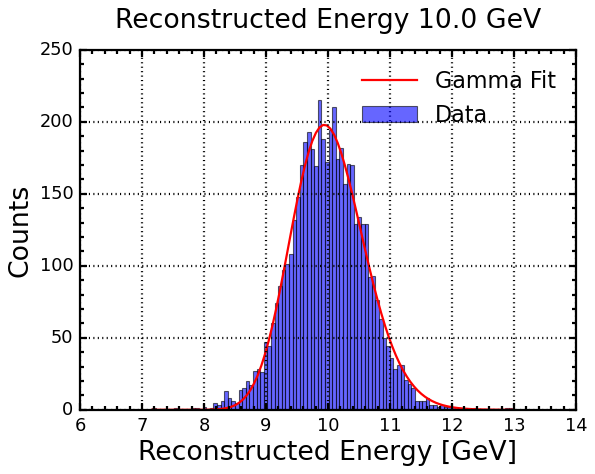

In [45]:
#This cell is left here for debug
print("length of Reco_hist_all:", len(Reco_hist_all))
Reco_hist = Reco_hist_all[0] # Example for first beta
print("length of Reco_hist:", len(Reco_hist))
i_E = 6 # Example index, change as needed
#print(len(Reco_hist))
#print(Reco_hist[i_E])
mean_gamma,mean_gamma_error,peak_gamma,peak_gamma_error,res_gamma,res_gamma_error = fit_all(
    "E_reco",Reco_hist[i_E]["E_truth"],Reco_hist[i_E]["counts"],Reco_hist[i_E]["bin_edges"])

Saving fit results to /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer30_in120/Reco_Results/RecoE_DGCNN_KNN8_WD1e-8_Fit.csv
Mean: 0.10471111106272867, Peak: 0.0549109866264395, RMS: 0.06270621253495308
Initial Gamma Fit Parameters: [np.float64(22.90212913933442), np.float64(1.0511783709562676), np.float64(0.0387956967213992), np.float64(0.06270621253495308)]
Gamma Fit Bounds: lower [np.float64(0.2290212913933442), np.float64(-0.8948821629043733), np.float64(-0.9961204303278601), np.float64(0.006270621253495309)], 
 upper [np.float64(137.41277483600652), np.float64(10.511783709562676), np.float64(10.0581935450821), np.float64(0.6270621253495308)]
Gamma Fit Parameters: [21.45015895  1.27708944  0.03885773  0.04355365]
Gamma Fit Peak: 0.050925986636389683 ± 0.0034210325680591475, Mean: 0.094479637955249 ± 0.006016874485620773, Resolution: 0.9664864625128335 ± 0.17303267045933826


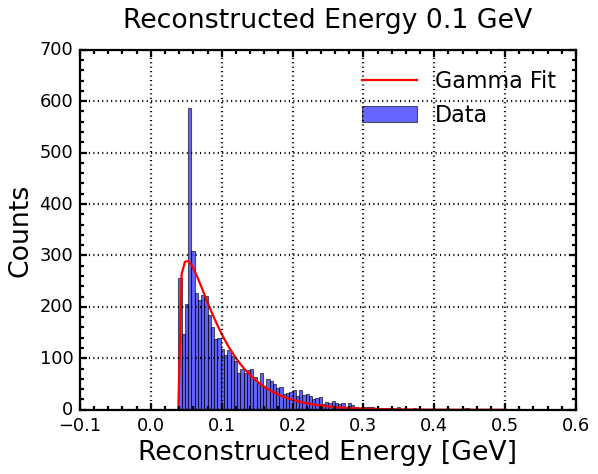

appending results for E = 0.1
Mean_Gamma: 0.094479637955249 Mean_Gamma_Error: 0.006016874485620773
Peak_Gamma: 0.050925986636389683 Peak_Gamma_Error: 0.0034210325680591475
Mean: 0.25490343315549796, Peak: 0.25290268865976917, RMS: 0.08509359008699796
Initial Gamma Fit Parameters: [np.float64(85.95286510379199), np.float64(2.5507790939152484), np.float64(0.037848482535389714), np.float64(0.08509359008699796)]
Gamma Fit Bounds: lower [np.float64(0.85952865103792), np.float64(-0.7449220906084751), np.float64(-0.996215151746461), np.float64(0.008509359008699797)], 
 upper [np.float64(515.717190622752), np.float64(25.507790939152486), np.float64(10.056772723803084), np.float64(0.8509359008699796)]
Gamma Fit Parameters: [ 8.38218283e+01  2.55077909e+01 -1.23508916e-01  1.48913002e-02]
Gamma Fit Peak: 0.2414439567146634 ± 0.0016714512901090121, Mean: 0.2563352569268615 ± 0.0016987574502904663, Resolution: 0.3114961648961359 ± 0.005923343506909379


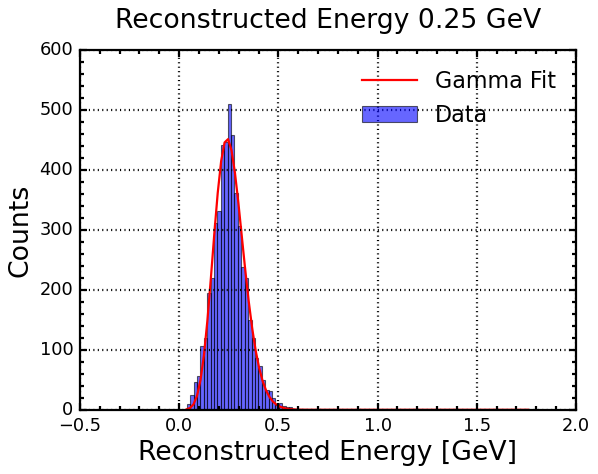

appending results for E = 0.25
Mean_Gamma: 0.2563352569268615 Mean_Gamma_Error: 0.0016987574502904663
Peak_Gamma: 0.2414439567146634 Peak_Gamma_Error: 0.0016714512901090121
Mean: 0.5071799877446824, Peak: 0.5148360169955905, RMS: 0.11920829281137217
Initial Gamma Fit Parameters: [np.float64(54.52684520805365), np.float64(3.9176160823871866), np.float64(0.04016766267293), np.float64(0.11920829281137217)]
Gamma Fit Bounds: lower [np.float64(0.5452684520805365), np.float64(-0.6082383917612812), np.float64(-0.995983233732707), np.float64(0.011920829281137219)], 
 upper [np.float64(327.1610712483219), np.float64(39.17616082387187), np.float64(10.060251494009394), np.float64(1.1920829281137217)]
Gamma Fit Parameters: [ 5.29097811e+01  3.91761608e+01 -1.64091064e-01  1.71885720e-02]
Gamma Fit Peak: 0.4921026237009585 ± 0.002368975756111809, Mean: 0.5092911956574765 ± 0.0023939403770941374, Resolution: 0.2186225990256833 ± 0.003698852634695925


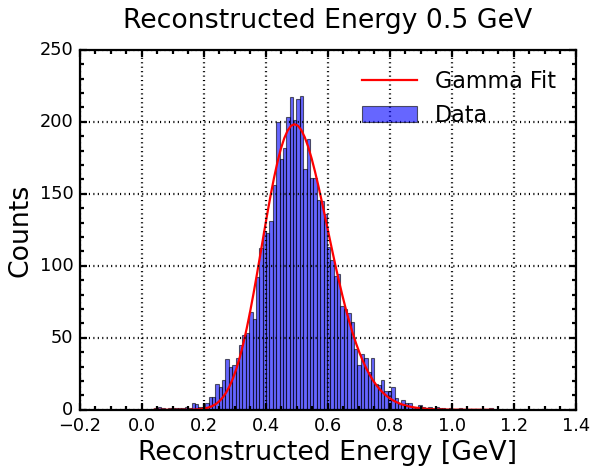

appending results for E = 0.5
Mean_Gamma: 0.5092911956574765 Mean_Gamma_Error: 0.0023939403770941374
Peak_Gamma: 0.4921026237009585 Peak_Gamma_Error: 0.002368975756111809
Mean: 1.0497639136248564, Peak: 1.0750357312696335, RMS: 0.16968619574580365
Initial Gamma Fit Parameters: [np.float64(79.69828378409306), np.float64(4.878658870034499), np.float64(0.22192284962718115), np.float64(0.16968619574580365)]
Gamma Fit Bounds: lower [np.float64(0.7969828378409307), np.float64(-0.51213411299655), np.float64(-0.9778077150372819), np.float64(0.016968619574580367)], 
 upper [np.float64(478.1897027045584), np.float64(48.78658870034499), np.float64(10.332884274440772), np.float64(1.6968619574580366)]
Gamma Fit Parameters: [ 7.94277679e+01  4.87865887e+01 -1.14041314e-01  2.39618500e-02]
Gamma Fit Peak: 1.0310137590745099 ± 0.0030467686466273194, Mean: 1.054975609122973 ± 0.0030724865803152656, Resolution: 0.1623327369652611 ± 0.0021537974177017246


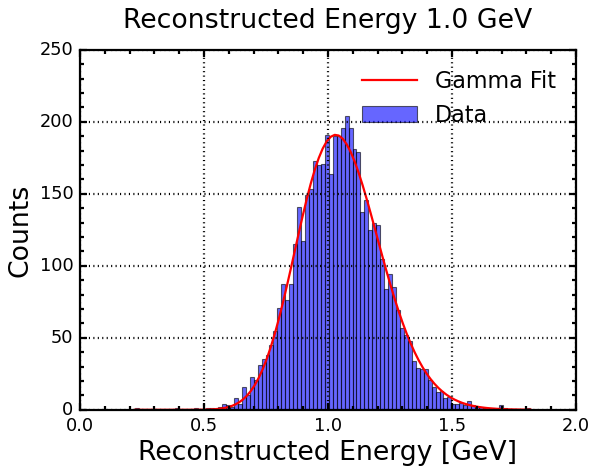

appending results for E = 1.0
Mean_Gamma: 1.054975609122973 Mean_Gamma_Error: 0.0030724865803152656
Peak_Gamma: 1.0310137590745099 Peak_Gamma_Error: 0.0030467686466273194
Mean: 2.0554574619600623, Peak: 2.020644315773385, RMS: 0.24805118356854533
Initial Gamma Fit Parameters: [np.float64(100.06127384602124), np.float64(4.1355019706395835), np.float64(1.029641303492862), np.float64(0.24805118356854533)]
Gamma Fit Bounds: lower [np.float64(1.0006127384602124), np.float64(-0.5864498029360417), np.float64(-0.8970358696507138), np.float64(0.024805118356854533)], 
 upper [np.float64(600.3676430761275), np.float64(41.35501970639584), np.float64(11.544461955239292), np.float64(2.480511835685453)]
Gamma Fit Parameters: [1.00166980e+02 3.21002953e+01 6.49522691e-01 4.39136021e-02]
Gamma Fit Peak: 2.015248687272248 ± 0.004581050082685942, Mean: 2.0591622893960193 ± 0.0046408096842165585, Resolution: 0.12345961828376402 ± 0.0016828108486446087


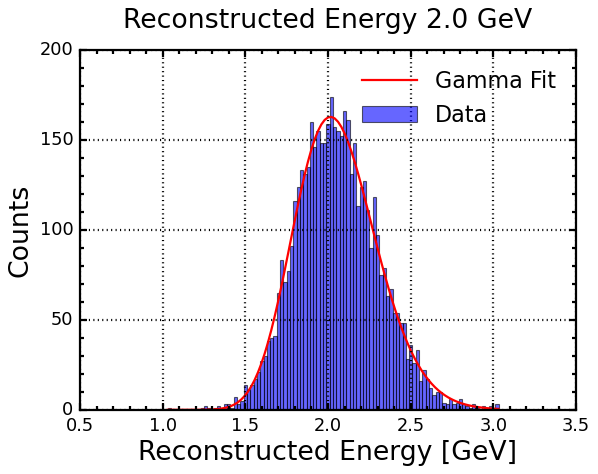

appending results for E = 2.0
Mean_Gamma: 2.0591622893960193 Mean_Gamma_Error: 0.0046408096842165585
Peak_Gamma: 2.015248687272248 Peak_Gamma_Error: 0.004581050082685942
Mean: 5.015281621713842, Peak: 4.836092761859052, RMS: 0.3964296753427779
Initial Gamma Fit Parameters: [np.float64(171.31705188903715), np.float64(4.821964802657234), np.float64(3.1037116804821325), np.float64(0.3964296753427779)]
Gamma Fit Bounds: lower [np.float64(1.7131705188903714), np.float64(-0.5178035197342765), np.float64(-0.6896288319517867), np.float64(0.03964296753427779)], 
 upper [np.float64(1027.9023113342228), np.float64(48.219648026572344), np.float64(14.6555675207232), np.float64(3.964296753427779)]
Gamma Fit Parameters: [1.70796752e+02 4.82196480e+01 2.30796861e+00 5.64371191e-02]
Gamma Fit Peak: 4.972909510015082 ± 0.008517026173284743, Mean: 5.029346629077484 ± 0.008590752092707352, Resolution: 0.07880727262446678 ± 0.0011965586311462788


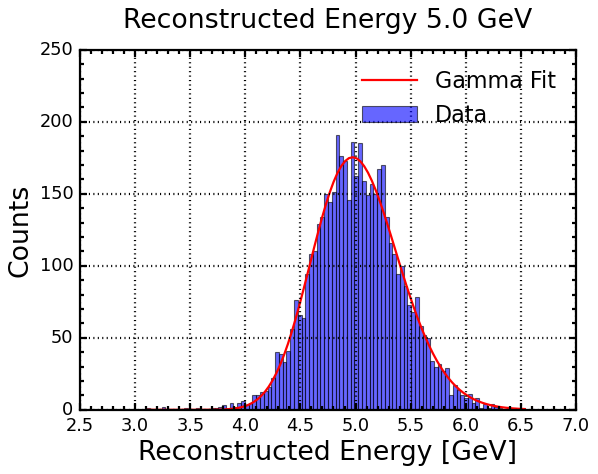

appending results for E = 5.0
Mean_Gamma: 5.029346629077484 Mean_Gamma_Error: 0.008590752092707352
Peak_Gamma: 4.972909510015082 Peak_Gamma_Error: 0.008517026173284743
Mean: 9.991273592309195, Peak: 9.865699119674503, RMS: 0.5997629694221589
Initial Gamma Fit Parameters: [np.float64(289.99317212119297), np.float64(4.710545254603811), np.float64(7.166062982810554), np.float64(0.5997629694221589)]
Gamma Fit Bounds: lower [np.float64(2.8999317212119298), np.float64(-0.5289454745396189), np.float64(-0.2833937017189445), np.float64(0.059976296942215894)], 
 upper [np.float64(1739.9590327271578), np.float64(47.10545254603811), np.float64(20.74909447421583), np.float64(5.9976296942215885)]
Gamma Fit Parameters: [2.88478974e+02 4.71054525e+01 6.00111073e+00 8.54862605e-02]
Gamma Fit Peak: 9.942493460012685 ± 0.011967573589186856, Mean: 10.027979720485327 ± 0.01207160940964975, Resolution: 0.059011492100349866 ± 0.0008350227477069068


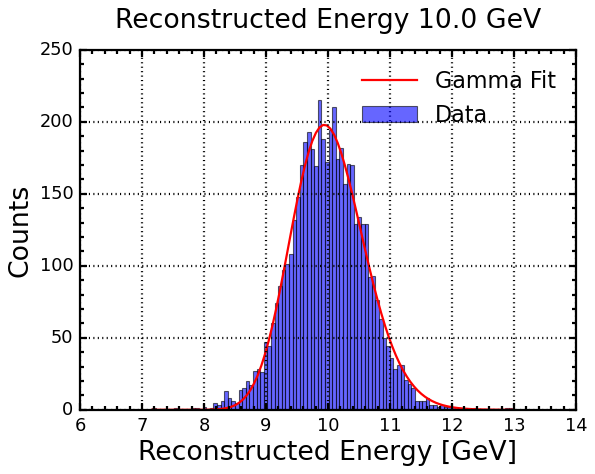

appending results for E = 10.0
Mean_Gamma: 10.027979720485327 Mean_Gamma_Error: 0.01207160940964975
Peak_Gamma: 9.942493460012685 Peak_Gamma_Error: 0.011967573589186856
Mean: 20.0805411765715, Peak: 20.07839134007469, RMS: 0.806211964577923
Initial Gamma Fit Parameters: [np.float64(322.4767696042492), np.float64(4.371295467897316), np.float64(16.556350469647434), np.float64(0.806211964577923)]
Gamma Fit Bounds: lower [np.float64(3.2247676960424925), np.float64(-0.5628704532102684), np.float64(0.6556350469647434), np.float64(0.08062119645779231)], 
 upper [np.float64(1934.8606176254953), np.float64(43.71295467897316), np.float64(34.83452570447115), np.float64(8.06211964577923)]
Gamma Fit Parameters: [3.20577065e+02 4.37129547e+01 1.48715824e+01 1.20392226e-01]
Gamma Fit Peak: 20.01389013779075 ± 0.017139978134346312, Mean: 20.13428236375676 ± 0.01730849083158469, Resolution: 0.039771503959987145 ± 0.000592779117757668


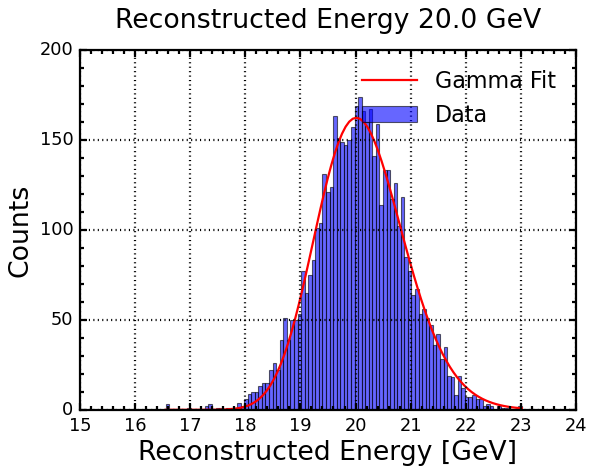

appending results for E = 20.0
Mean_Gamma: 20.13428236375676 Mean_Gamma_Error: 0.01730849083158469
Peak_Gamma: 20.01389013779075 Peak_Gamma_Error: 0.017139978134346312
Mean: 29.661965732157235, Peak: 29.534061330475588, RMS: 0.9795603531094601
Initial Gamma Fit Parameters: [np.float64(395.525187623815), np.float64(4.3719416865674985), np.float64(25.379384989889207), np.float64(0.9795603531094601)]
Gamma Fit Bounds: lower [np.float64(3.95525187623815), np.float64(-0.5628058313432501), np.float64(1.5379384989889209), np.float64(0.09795603531094602)], 
 upper [np.float64(2373.15112574289), np.float64(43.71941686567499), np.float64(48.06907748483381), np.float64(9.795603531094601)]
Gamma Fit Parameters: [3.95023270e+02 4.37194169e+01 2.32660746e+01 1.48099072e-01]
Gamma Fit Peak: 29.592780617347817 ± 0.02369432985333161, Mean: 29.74087968914251 ± 0.02392716456823255, Resolution: 0.0330905314635065 ± 0.0005527458817054364


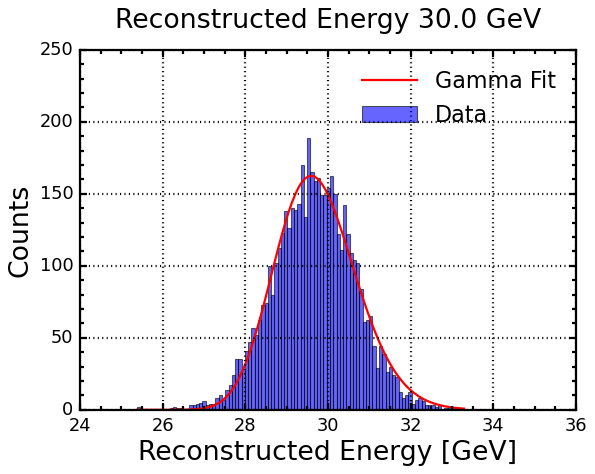

appending results for E = 30.0
Mean_Gamma: 29.74087968914251 Mean_Gamma_Error: 0.02392716456823255
Peak_Gamma: 29.592780617347817 Peak_Gamma_Error: 0.02369432985333161
Mean: 39.10574968339345, Peak: 39.44664039040718, RMS: 1.1180307232818119
Initial Gamma Fit Parameters: [np.float64(482.1631825426701), np.float64(4.396783743361727), np.float64(34.190010374689024), np.float64(1.1180307232818119)]
Gamma Fit Bounds: lower [np.float64(4.821631825426701), np.float64(-0.5603216256638273), np.float64(2.4190010374689024), np.float64(0.1118030723281812)], 
 upper [np.float64(2892.9790952560206), np.float64(43.96783743361727), np.float64(61.285015562033536), np.float64(11.18030723281812)]
Gamma Fit Parameters: [4.81154577e+02 4.39678374e+01 3.18113546e+01 1.67382914e-01]
Gamma Fit Peak: 39.003436372271 ± 0.020388308625343358, Mean: 39.170819285853014 ± 0.02057854204167308, Resolution: 0.02845612788281194 ± 0.0003600139201379843


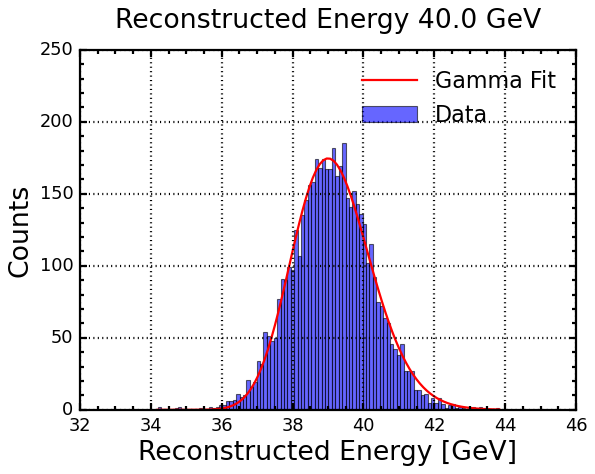

appending results for E = 40.0
Mean_Gamma: 39.170819285853014 Mean_Gamma_Error: 0.02057854204167308
Peak_Gamma: 39.003436372271 Peak_Gamma_Error: 0.020388308625343358
Mean: 48.38880529873517, Peak: 48.77581947236584, RMS: 1.2255182605767128
Initial Gamma Fit Parameters: [np.float64(557.4040362863846), np.float64(4.006829854750704), np.float64(43.47836214471425), np.float64(1.2255182605767128)]
Gamma Fit Bounds: lower [np.float64(5.574040362863846), np.float64(-0.5993170145249296), np.float64(3.3478362144714247), np.float64(0.12255182605767129)], 
 upper [np.float64(3344.4242177183073), np.float64(40.06829854750704), np.float64(75.21754321707137), np.float64(12.255182605767128)]
Gamma Fit Parameters: [5.54630733e+02 4.00682985e+01 4.07772660e+01 1.92193305e-01]
Gamma Fit Peak: 48.285931384984345 ± 0.028693045310401035, Mean: 48.47812468952949 ± 0.02898614678534403, Resolution: 0.02519521633120215 ± 0.00041165005362270556


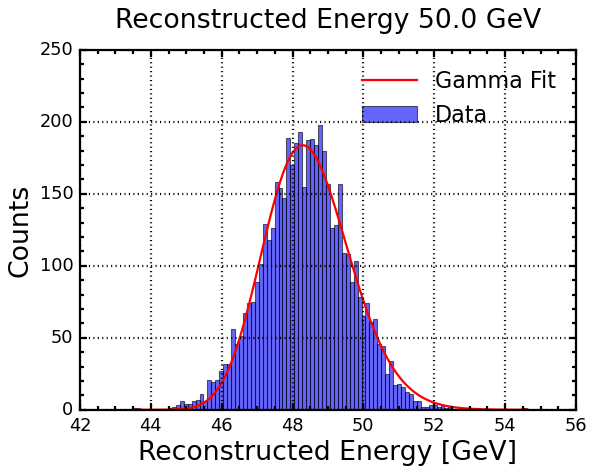

appending results for E = 50.0
Mean_Gamma: 48.47812468952949 Mean_Gamma_Error: 0.02898614678534403
Peak_Gamma: 48.285931384984345 Peak_Gamma_Error: 0.028693045310401035
Mean: 56.97105829118115, Peak: 57.10934563595091, RMS: 1.2218673487289278
Initial Gamma Fit Parameters: [np.float64(494.3084110586191), np.float64(4.624814852530002), np.float64(51.32014802895815), np.float64(1.2218673487289278)]
Gamma Fit Bounds: lower [np.float64(4.943084110586191), np.float64(-0.5375185147469999), np.float64(4.1320148028958155), np.float64(0.12218673487289278)], 
 upper [np.float64(2965.850466351714), np.float64(46.24814852530002), np.float64(86.98022204343722), np.float64(12.218673487289278)]
Gamma Fit Parameters: [4.92665292e+02 4.62481485e+01 4.88590126e+01 1.78538607e-01]
Gamma Fit Peak: 56.9375540318122 ± 0.027725033386165575, Mean: 57.116092639189155 ± 0.028004731520102997, Resolution: 0.02132458126481479 ± 0.00033344221089094965


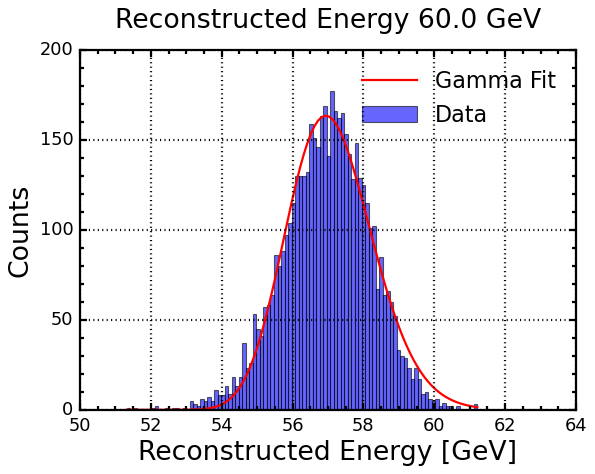

appending results for E = 60.0
Mean_Gamma: 57.116092639189155 Mean_Gamma_Error: 0.028004731520102997
Peak_Gamma: 56.9375540318122 Peak_Gamma_Error: 0.027725033386165575


In [46]:
#Fit RecoE and Save as CSV
#Gauss and LogNormal were not fitted but saved as 0 to keep format
def OutputCSV(Reco_hist, Energy_test, CSV_name):
    results = []
    for i_E in range(len(Energy_test)):
        mean_gauss,mean_gauss_error,peak_gauss, peak_gauss_error, res_gauss, res_gauss_error = 0, 0, 0, 0, 0, 0
        mean_log_normal,mean_log_normal_error,peak_log_normal, peak_log_normal_error, res_log_normal, res_log_normal_error = 0, 0, 0, 0, 0, 0
        mean_gamma,mean_gamma_error,peak_gamma, peak_gamma_error, res_gamma, res_gamma_error = fit_all("E_reco",Reco_hist[i_E]["E_truth"],Reco_hist[i_E]["counts"],Reco_hist[i_E]["bin_edges"])
        print("appending results for E =", Energy_test[i_E])
        print("Mean_Gamma:", mean_gamma, "Mean_Gamma_Error:", mean_gamma_error)
        print("Peak_Gamma:", peak_gamma, "Peak_Gamma_Error:", peak_gamma_error)
        results.append({
            "ParticleEnergy": Energy_test[i_E],
            "Mean_Gauss": mean_gauss,
            "Mean_Gauss_Error": mean_gauss_error,
            "Peak_Gauss": peak_gauss,
            "Peak_Gauss_Error": peak_gauss_error,
            "Res_Gauss": res_gauss,
            "Res_Gauss_Error": res_gauss_error,
            "Mean_Gamma": mean_gamma,
            "Mean_Gamma_Error": mean_gamma_error,
            "Peak_Gamma": peak_gamma,
            "Peak_Gamma_Error": peak_gamma_error,
            "Res_Gamma": res_gamma,
            "Res_Gamma_Error": res_gamma_error,
            "Mean_LogNormal": mean_log_normal,
            "Mean_LogNormal_Error": mean_log_normal_error,
            "Peak_LogNormal": peak_log_normal,
            "Peak_LogNormal_Error": peak_log_normal_error,
            "Res_LogNormal": res_log_normal,
            "Res_LogNormal_Error": res_log_normal_error,
            "Best_Val_Loss": best_val_loss
        })
    df = pd.DataFrame(results)
    df.to_csv(CSV_name, index=False)
outputfile_name = os.path.join(DataPath_Validate, f"Reco_Results/RecoE_DGCNN_{CONF_NAME}_Fit.csv")
print(f"Saving fit results to {outputfile_name}")
OutputCSV(Reco_hist_all[0], Energy_test, outputfile_name)
# for i_para, para in enumerate(ParameterScan):
#     if i_para != 0:
#         continue  # 
#     #outputfile_name = os.path.join(DataPath_Validate, f"Reco_Results/RecoE_MLP_LR{para:.0e}_Fit.csv")
#     outputfile_name = os.path.join(DataPath_Validate, f"Reco_Results/RecoE_MLP_Fit.csv")
#     OutputCSV(Reco_hist_mlp_all[i_para], Energy_test, outputfile_name)
#     print(f"Saved fit results to {outputfile_name}")